# Predicción de Series Temporales NN - Multivariante


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pylab as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('time_series_eximben.csv',  parse_dates=[0], header=None,index_col=0, names=['fecha','unidades'])
df.head()

Using TensorFlow backend.


,unidades
fecha,
2014-01-02,18
2014-01-03,28
2014-01-04,24
2014-01-06,27
2014-01-07,18


# Cargamos datos categóricos: Día y Mes

In [2]:
df['weekday']=[x.weekday() for x in df.index]
df['month']=[x.month for x in df.index]
#df['year']=[x.year for x in df.index]
df.head()

,unidades,weekday,month
fecha,,,
2014-01-02,18,3,1
2014-01-03,28,4,1
2014-01-04,24,5,1
2014-01-06,27,0,1
2014-01-07,18,1,1


In [3]:
print(len(df['2017']))
print(len(df['2018']))
print(len(df))
df.describe()

312
315
1488


,unidades,weekday,month
count,1488.000000,1488.000000,1488.000000
mean,20.010081,2.659274,6.727151
std,11.535998,1.806037,3.456641
min,1.000000,0.000000,1.000000
25%,12.000000,1.000000,4.000000
50%,18.000000,3.000000,7.000000
75%,25.000000,4.000000,10.000000
max,85.000000,6.000000,12.000000


# Reprocesado de los datos

In [0]:

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [5]:
PASOS=7

# load dataset
values = df['unidades'].values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)

df['scaled'] = scaled
scaledMerge=df.drop('unidades',axis=1)
print(scaledMerge.values)

# frame as supervised learning
reframed = series_to_supervised(scaledMerge, PASOS, 1)
reframed.head()

[[ 3.          1.         -0.59523809]
 [ 4.          1.         -0.35714287]
 [ 5.          1.         -0.45238096]
 ...
 [ 4.         12.         -0.5714286 ]
 [ 5.         12.         -0.61904764]
 [ 0.         12.         -0.88095242]]


,var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),...,var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
fecha,,,,,,,,,,,,,,,,,,,,,
2014-01-10,3.0,1.0,-0.595238,4.0,1.0,-0.357143,5.0,1.0,-0.452381,0.0,...,-0.595238,2.0,1.0,-0.333333,3.0,1.0,-0.523810,4,1,-0.595238
2014-01-11,4.0,1.0,-0.357143,5.0,1.0,-0.452381,0.0,1.0,-0.380952,1.0,...,-0.333333,3.0,1.0,-0.523810,4.0,1.0,-0.595238,5,1,-0.023810
2014-01-13,5.0,1.0,-0.452381,0.0,1.0,-0.380952,1.0,1.0,-0.595238,2.0,...,-0.523810,4.0,1.0,-0.595238,5.0,1.0,-0.023810,0,1,-0.428571
2014-01-14,0.0,1.0,-0.380952,1.0,1.0,-0.595238,2.0,1.0,-0.333333,3.0,...,-0.595238,5.0,1.0,-0.023810,0.0,1.0,-0.428571,1,1,-0.571429
2014-01-15,1.0,1.0,-0.595238,2.0,1.0,-0.333333,3.0,1.0,-0.523810,4.0,...,-0.023810,0.0,1.0,-0.428571,1.0,1.0,-0.571429,2,1,-0.500000


#Dividimos en set de Entreamiento y Validación

In [6]:
newReframed=reframed.drop(['var1(t)','var2(t)'],axis=1)
print(newReframed.shape)
newReframed.head()

(1481, 22)


,var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),...,var1(t-3),var2(t-3),var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var3(t)
fecha,,,,,,,,,,,,,,,,,,,,,
2014-01-10,3.0,1.0,-0.595238,4.0,1.0,-0.357143,5.0,1.0,-0.452381,0.0,...,1.0,1.0,-0.595238,2.0,1.0,-0.333333,3.0,1.0,-0.523810,-0.595238
2014-01-11,4.0,1.0,-0.357143,5.0,1.0,-0.452381,0.0,1.0,-0.380952,1.0,...,2.0,1.0,-0.333333,3.0,1.0,-0.523810,4.0,1.0,-0.595238,-0.023810
2014-01-13,5.0,1.0,-0.452381,0.0,1.0,-0.380952,1.0,1.0,-0.595238,2.0,...,3.0,1.0,-0.523810,4.0,1.0,-0.595238,5.0,1.0,-0.023810,-0.428571
2014-01-14,0.0,1.0,-0.380952,1.0,1.0,-0.595238,2.0,1.0,-0.333333,3.0,...,4.0,1.0,-0.595238,5.0,1.0,-0.023810,0.0,1.0,-0.428571,-0.571429
2014-01-15,1.0,1.0,-0.595238,2.0,1.0,-0.333333,3.0,1.0,-0.523810,4.0,...,5.0,1.0,-0.023810,0.0,1.0,-0.428571,1.0,1.0,-0.571429,-0.500000


In [7]:
# split into train and test sets
values = newReframed.values
n_train_days = 1488 - (30+PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(1451, 1, 21) (1451,) (30, 1, 21) (30,)


#Creamos el Modelo de Red Neuronal
**Utilizaremos una Red Feedforward**

In [0]:
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS*3),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

**Etrenamos nuestra máquina**

In [9]:
EPOCHS=40

model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1, 7)              154       
_________________________________________________________________
flatten_1 (Flatten)          (None, 7)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 8         
Total params: 162
Trainable params: 162
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 1451 samples, validate on 30 samples
Epoch 1/40
1451/1451 [==============================] - 1s 610us/step - loss: 0.4929 - mean_squared_error: 0.5232 - val_loss: 0.2483 - val_mean_squared_error: 0.0784
Epoch 2/40
1451/1451 [==============================] - 0s 167us/step - loss

**Visualizamos Resultados**

30


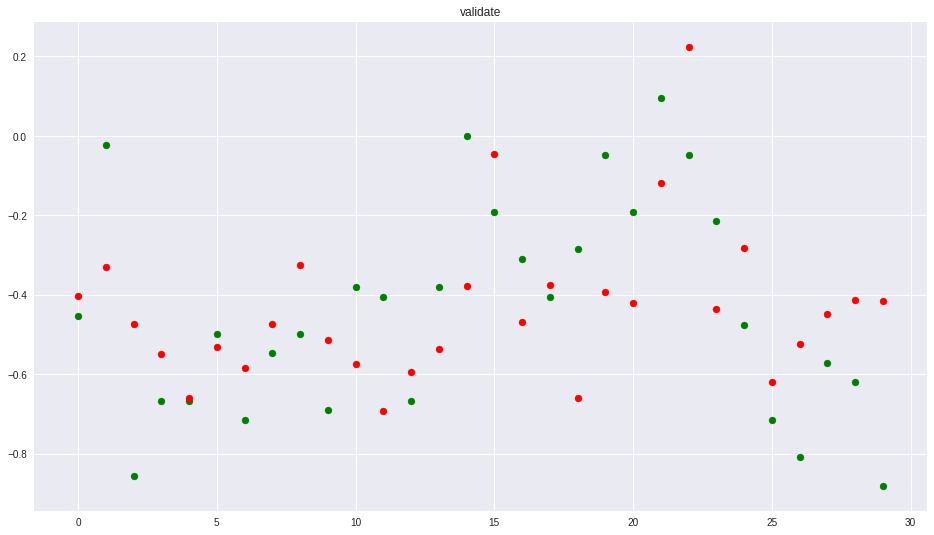

In [10]:

results=model.predict(x_val)
print( len(results) )
plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

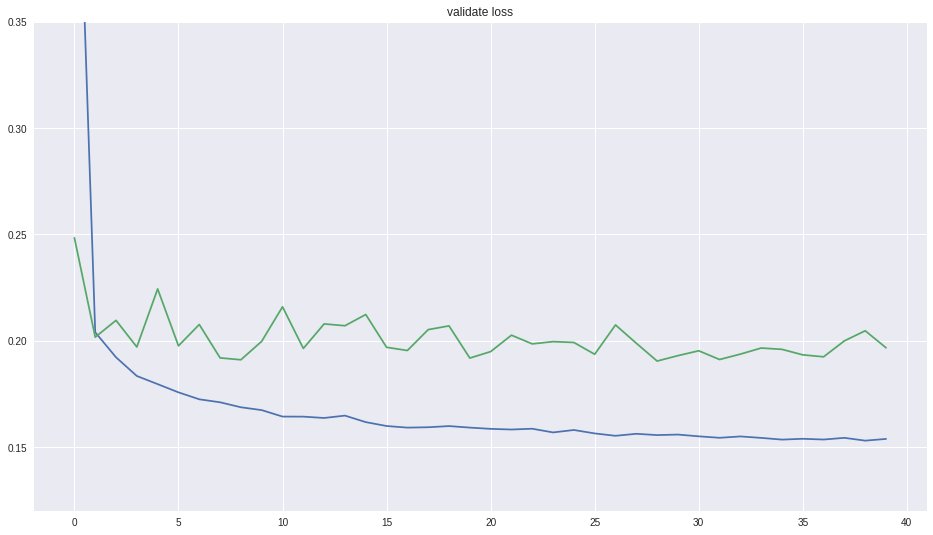

In [11]:
plt.ylim(0.12, 0.35)
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

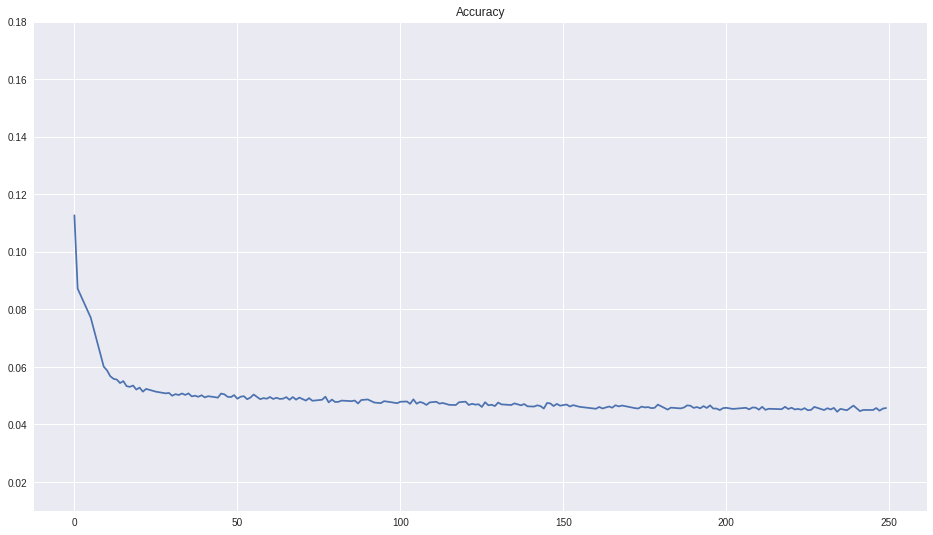

In [0]:

plt.ylim(0.01, 0.18)
plt.title('Accuracy')
plt.plot(history.history['mean_squared_error'])
plt.show()

In [12]:
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head(10)

,real,prediccion,diferencia
0,24.000001,26.063771,-2.063770
1,41.999999,29.124891,12.875108
2,7.000001,23.086775,-16.086774
3,15.000000,19.960465,-4.960465
4,15.000000,15.289055,-0.289055
5,22.000001,20.708286,1.291714
6,13.000000,18.431641,-5.431641
7,19.999998,23.099983,-3.099984
8,22.000001,29.356972,-7.356971
9,14.000001,21.460149,-7.460147


In [0]:
compara2.describe()

,real,prediccion,diferencia
count,365.000000,365.000000,365.000000
mean,17.583562,15.959199,1.624362
std,9.550143,6.082474,7.955107
min,3.000001,8.717042,-21.922888
25%,11.000000,11.040395,-3.237548
50%,15.999999,14.253332,0.738449
75%,22.999999,18.985115,5.938451
max,56.000001,44.540893,36.519687


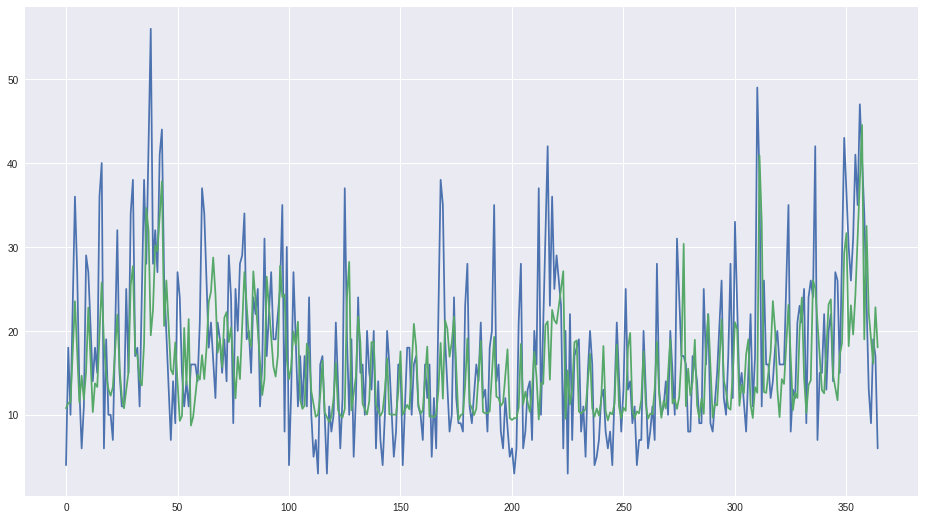

In [0]:
compara2['real'].plot()
compara2['prediccion'].plot()

# Pronóstico
A partir de la última semana de diciembre 2018, intentaremos predecir la primer semana de enero.

In [0]:
ultimosDias = df['2018-01-01':'2018-01-07']
ultimosDias

,unidades,weekday,month,scaled
fecha,,,,
2018-01-02,27,1,1,-0.380952
2018-01-03,24,2,1,-0.452381
2018-01-04,15,3,1,-0.666667
2018-01-05,11,4,1,-0.761905
2018-01-06,14,5,1,-0.690476


# Preparamos los datos para el TEST

In [0]:
scaledMerge=ultimosDias.drop('unidades',axis=1)
print(scaledMerge.values)

# frame as supervised learning
reframed = series_to_supervised(scaledMerge, PASOS, 1)
newReframed=reframed.drop(['var1(t)','var2(t)','var3(t)'],axis=1)
newReframed.head(7)

[[ 1.          1.         -0.38095242]
 [ 2.          1.         -0.45238096]
 [ 3.          1.         -0.66666669]
 [ 4.          1.         -0.76190478]
 [ 5.          1.         -0.69047618]]


,var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),...,var3(t-4),var1(t-3),var2(t-3),var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1)
fecha,,,,,,,,,,,,,,,,,,,,,


In [0]:
values = newReframed.values
x_test = values[6:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
print(x_test)
ultDiaSemana = newReframed.index[len(newReframed.index)-1].weekday()

(0, 1, 21)
[]


IndexError: ignored

In [0]:
def agregarNuevoValor(x_test,nuevoValor,ultDiaSemana):
    for i in range(x_test.shape[2]-3):
        x_test[0][0][i] = x_test[0][0][i+3]
    ultDiaSemana=ultDiaSemana+1
    if ultDiaSemana>6:
        ultDiaSemana=0
    x_test[0][0][x_test.shape[2]-3]=ultDiaSemana
    x_test[0][0][x_test.shape[2]-2]=12
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test,ultDiaSemana

# Pronóstico para la "próxima semana"

In [0]:
results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print('pred',i,x_test)
    x_test,ultDiaSemana=agregarNuevoValor(x_test,parcial[0],ultDiaSemana)

IndexError: ignored

# Re-Convertimos los resultados

In [0]:
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)
inverted

[array([-0.77782685], dtype=float32), array([-0.650196], dtype=float32), array([-0.56513226], dtype=float32), array([-0.45231947], dtype=float32), array([-0.36270967], dtype=float32), array([-0.6356613], dtype=float32), array([-0.6588002], dtype=float32), array([-0.59637916], dtype=float32), array([-0.6537903], dtype=float32), array([-0.4622904], dtype=float32), array([-0.2806425], dtype=float32), array([-0.63123995], dtype=float32), array([-0.70786524], dtype=float32), array([-0.64726794], dtype=float32), array([-0.60934883], dtype=float32), array([-0.39229688], dtype=float32), array([-0.15435967], dtype=float32), array([-0.57699853], dtype=float32), array([-0.5433467], dtype=float32), array([-0.6474277], dtype=float32), array([-0.6327037], dtype=float32), array([-0.5818388], dtype=float32), array([-0.47201368], dtype=float32), array([-0.36973786], dtype=float32), array([-0.65788007], dtype=float32), array([-0.5658327], dtype=float32), array([-0.7396661], dtype=float32), array([-0.598

array([[10.33127348],
       [15.69176823],
       [19.2644459 ],
       [24.00258288],
       [27.76619448],
       [16.30222612],
       [15.33039315],
       [17.9520761 ],
       [15.54080851],
       [23.58380369],
       [31.21301521],
       [16.48792296],
       [13.26966094],
       [15.81474752],
       [17.40734986],
       [26.52353172],
       [36.51689444],
       [18.76606251],
       [20.17943929],
       [15.80803842],
       [16.42644458],
       [18.56277181],
       [23.17542611],
       [27.47101041],
       [15.36903806],
       [19.2350285 ],
       [11.93402459],
       [17.86890581],
       [21.92861397],
       [29.13428109],
       [38.81889916],
       [17.85248854],
       [22.63908624],
       [17.7116225 ],
       [18.2426727 ],
       [23.82035449],
       [39.48192396],
       [39.37435089],
       [20.30463908],
       [31.54562879],
       [25.2716477 ],
       [34.92171234],
       [49.92767551],
       [43.61113584],
       [25.66761345],
       [28

# Visualizamos el prónostico

In [0]:
prediccion1SemanaDiciembre = pd.DataFrame(inverted)
prediccion1SemanaDiciembre.columns = ['pronostico']
prediccion1SemanaDiciembre.plot()
prediccion1SemanaDiciembre.to_csv('pronostico_multivariate.csv')
prediccion1SemanaDiciembre

NameError: ignored